# Table of Contents
#### [Preprocessing](#0)

#### [Determinants of House Prices](#1)

   - [Generalized Least Squares](#11)
   - [GBMs: Global Features Importances](#12)
   - [GBMs: Local Explanations with Shapley Values](#13)
    
    
#### [Clustering Houses](#2)

   - [Dimensionality Reduction](#21)
   - [Clustering](#22)
   - [Factor Analysis](#23)

<div id='0'/>

# Preprocessing

In [1]:
# Warnings & Display options
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Load the Data
# We work on a sample to prevent some algorithms from taking too much time. 
path = '../input/mse-pysupport-hackathon/simulation.csv'
df = pd.read_csv(path).sample(frac = 0.1)

In [2]:
# We may work with log SalePrice as that is much less skewed and helps in interpretation
df['TSalePrice'] = np.log1p(df['SalePrice']) 

# Key Variables
df['PastMV'] = df['EstimateLand'] + df['EstimateBuilding']
df['BuildingArea'] = df['BuildingSquareFeet']
df['BedroomShare'] = df['Bedrooms']/df['Rooms']
df['SaleYear'] = df['SaleDate'].str[-4:]

# (Interior) Furnishing Quality - a simple score that is higher if the house has high quality interiors
df['FurnishingQuality'] = 0
df.loc[df.ConstructionQuality == 'Deluxe', 'FurnishingQuality'] += 1
df.loc[df.BasementFinish == 'FormalRecRoom', 'FurnishingQuality'] += 1
df.loc[df.CentralHeating == 'HotWaterStream', 'FurnishingQuality'] += 1
df.loc[df.AtticFinish == 'LivingArea', 'FurnishingQuality'] += 1
df.loc[df.WallMaterial.isin(['Stucco', 'Masonry']), 'FurnishingQuality'] += 1
df.loc[df.RoofMaterial.isin(['Shake', 'Slate', 'Tile']), 'FurnishingQuality'] += 1
df.loc[df.DesignPlan == 'ArchitectPlan', 'FurnishingQuality'] += 1
df.loc[df.RepairCondition == 'AboveAvg', 'FurnishingQuality'] += 1
df.loc[df.Garage1Material.isin(['Stucco', 'Masonry']) |
       df.Garage2Material.isin(['Stucco', 'Masonry']), 'FurnishingQuality'] += 1

# (Interior) Furshining Quantity - a score that captures if the house has a porch, garage, basement, etc.
df['Furnishing'] = 0
df.loc[df.GarageIndicator == 1.0, 'Furnishing'] += 1
df.loc[df.Porch != 'None', 'Furnishing'] += 1
df.loc[df.CathedralCeiling != 'None', 'Furnishing'] += 1
df.loc[df.AtticType != 'None', 'Furnishing'] += 1
df.loc[df.Fireplaces != 0.0, 'Furnishing'] += 1
df.loc[df.Basement.isin(['Full', 'Partial']), 'Furnishing'] += 1

In [3]:
# Both Seem evenly distributed
df.FurnishingQuality.value_counts()

0    19174
1    10629
2     7491
3     2807
4      580
5      122
6       27
7        5
8        1
Name: FurnishingQuality, dtype: int64

In [4]:
df.Furnishing.value_counts()

3    20839
2     7305
4     6637
1     3135
5     2071
0      603
6      246
Name: Furnishing, dtype: int64

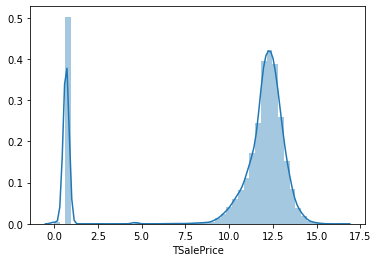

In [5]:
# Log transforming SalePrice reveals a bimodal distribution. 
# Some values below k, where log(k) = 5 are too low to be considered. 
import seaborn as sns
import numpy as np
sns.distplot(df.TSalePrice)

In [6]:
# Arms Length Transactions are sales made between family or known members.
# They are more erratic. 
df[['SalePrice', 'ArmsLengthTransaction']].groupby('ArmsLengthTransaction').describe()

SalePrice                                                                                 
                          count           mean            std      min       25%       50%       75%         max
ArmsLengthTransaction                                                                                           
0                        7299.0   25750.015619  290695.551285      0.0       1.0       1.0       1.0  13300000.0
1                       33537.0  273544.671139  270848.393113  10009.0  119000.0  205000.0  340000.0   4800000.0

In [7]:
# Also remove Condos and Apartments. 
# Condos are close knit shared community living (their price depends on % ownership, and the data for them is lesser).
# Apartments can house multiple families in them (the rooms in them are much larger).
# We retain only Single Family Houses for simplicity. 
df2 = df[(df.TSalePrice > 5) & (df.ArmsLengthTransaction == 1) & 
       (~df.PropertyDesc.isin(['Residential condominium', 
                               'Apartment building with 2 to 6 units, any age', 
                               'Mixed-use commercial/residential building with apartment and commercial area totaling 6 units or less with a square foot area less than 20,000 square feet, any age']))]


#df2 = df2[(df2.TSalePrice < df2.TSalePrice.quantile(.9)) | (df2.TSalePrice > df2.TSalePrice.quantile(.1))]

In [8]:
# Optionally you way want to truncate the data to remove all extreme values based on price
#df2 = df2[(df2.TSalePrice < df2.TSalePrice.quantile(.9)) | (df2.TSalePrice > df2.TSalePrice.quantile(.1))]

In [9]:
# Attributes of Interest - a small set to keep things simple
cols = ['Age', 'BuildingArea', 'BedroomShare', 'Furnishing','FurnishingQuality',
        'OHareNoise','Floodplain', 'RoadProximity', 'SaleYear', 'TownshipName', 'NeighborhoodCode']

#cols = ['BuildingArea', 'Furnishing','FurnishingQuality']
#'OtherRoomsShare','AvgRoomSize', 
x = df2[cols]
#x = df2[list(df2.select_dtypes(exclude = 'object').columns) + ['SaleYear', 'TownshipName', 'NeighborhoodCode']].dropna()

# SalePrice
y = df2[['SalePrice']]

# Filling Nulls - all these are indicator variables with 
na1 = ['OHareNoise','Floodplain', 'RoadProximity']
x[na1] = x[na1].fillna(0)

In [10]:
x.isnull().sum()

Age                  0
BuildingArea         0
BedroomShare         0
Furnishing           0
FurnishingQuality    0
OHareNoise           0
Floodplain           0
RoadProximity        0
SaleYear             0
TownshipName         0
NeighborhoodCode     0
dtype: int64

In [11]:
# Creating dummies for the three Categorical variables
# Keep the most common categorical value as base
dum = [ 'OHareNoise','Floodplain', 'RoadProximity','TownshipName', 'SaleYear', 'NeighborhoodCode']
dum_base = {}
for i in dum:
    base = str(i) + '_' + str(x[i].value_counts().index[0])
    print(str(i), ' base is ', base)
    x[i] = pd.Categorical(x[i], x[i].value_counts().index)
    x.sort_values(i, inplace = True)
    for col in pd.get_dummies(x[i], drop_first = True, prefix = str(i)).columns:
        dum_base[str(col)] = base
    x = pd.concat([x.drop(i, axis = 1), pd.get_dummies(x[i], drop_first = True, prefix = str(i))], axis = 1, ignore_index = False)
    
x.sort_index(inplace = True)
y.sort_index(inplace = True)

OHareNoise  base is  OHareNoise_0.0
Floodplain  base is  Floodplain_0.0
RoadProximity  base is  RoadProximity_0.0
TownshipName  base is  TownshipName_Lake
SaleYear  base is  SaleYear_2018
NeighborhoodCode  base is  NeighborhoodCode_30


In [12]:
# Sanity Checks

# Zillow claims Cook County area has a market value of 200-250k$
print(y.median())

# Shapes
print(x.shape, y.shape)

x.head()

SalePrice    215000.0
dtype: float64
(19728, 247) (19728, 1)


Age  BuildingArea  BedroomShare  Furnishing  FurnishingQuality  OHareNoise_1.0  Floodplain_1.0  RoadProximity_1.0  TownshipName_Jefferson  TownshipName_Thornton  TownshipName_Hyde Park  TownshipName_Proviso  TownshipName_Wheeling  TownshipName_Worth  TownshipName_Schaumburg  TownshipName_Maine  TownshipName_Bremen  TownshipName_West Chicago  TownshipName_Palatine  TownshipName_Hanover  TownshipName_Lyons  TownshipName_Orland  TownshipName_Rich  TownshipName_Bloom  TownshipName_Northfield  TownshipName_New Trier  TownshipName_Niles  TownshipName_Leyden  TownshipName_Lake View  TownshipName_Elk Grove  TownshipName_Palos  TownshipName_Evanston  TownshipName_Berwyn  TownshipName_Oak Park  TownshipName_South Chicago  TownshipName_Stickney  TownshipName_Cicero  TownshipName_Lemont  TownshipName_Norwood Park  TownshipName_Riverside  TownshipName_North Chicago  TownshipName_Barrington  TownshipName_Rogers Park  TownshipName_Calumet  TownshipName_River Forest  SaleYear_2019  \
18   30        2406.0      0.571429           3                  1               0               0                  0                       0                      0                       0                     0                      0                   0                        0                   0                    0                          0                      0                     0                   0                    1                  0                   0                        0                       0                   0                    0                       0                       0                   0                      0                    0                      0                           0                      0                    0                    0                          0                       0                           0                        0                         0                     0                          0              0   
24   55        1135.0      0.600000           1                  1               0               0                  0                       0                      0                       0                     0                      1                   0                        0                   0                    0                          0                      0                     0                   0                    0                  0                   0                        0                       0                   0                    0                       0                       0                   0                      0                    0                      0                           0                      0                    0                    0                          0                       0                           0                        0                         0                     0                          0              0   
27   27        1030.0      0.400000           4                  1               0               0                  0                       0                      0                       0                     0                      0                   0                        0                   0                    0                          0                      1                     0                   0                    0                  0                   0                        0                       0                   0                    0                       0                       0                   0                      0                    0                      0                           0                      0                    0                    0                          0                       0                           0                        0                         0                     0                          0              0   
46   65        1104.0      0.600000           3         

<div id='1'/>

# Determinants of House Prices

<div id='11'/>

### Generalized Least Squares

In [13]:
# We use the GLS to correct for heteroskedasticity, since SalePrice is skewed. 
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import GLS
x = sm.add_constant(x, prepend=False)
mod = GLS(y, x)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.713
Model:                            GLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     195.5
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:44:34   Log-Likelihood:            -2.6491e+05
No. Observations:               19728   AIC:                         5.303e+05
Df Residuals:                   19480   BIC:                         5.323e+05
Df Model:                         247                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Age                         -470.2635     51.346     -9.159      0.000    -570.905    -369.622
BuildingArea                 193.6521      1.927    100.501      0.000     189.875     197.429
BedroomShare               -1.192e+04   1.39e+04     -0.855      0.393   -3.93e+04    1.54e+04
Furnishing                  7695.9753   1181.287      6.515      0.000    5380.552       1e+04
FurnishingQuality           1.479e+04   1308.627     11.304      0.000    1.22e+04    1.74e+04
OHareNoise_1.0              1.725e+04   1.32e+04      1.307      0.191   -8615.008    4.31e+04
Floodplain_1.0             -1.414e+04   7485.100     -1.889      0.059   -2.88e+04     530.230
RoadProximity_1.0            -2.7e+04   4542.211     -5.944      0.000   -3.59e+04   -1.81e+04
TownshipName_Jefferson      1.406e+05   7633.376     18.414      0.000    1.26e+05    1.56e+05
TownshipName_Thornton      -5.851e+04   9298.604     -6.292      0.000   -7.67e+04   -4.03e+04
TownshipName_Hyde Park      -2.86e+04   8575.509     -3.335      0.001   -4.54e+04   -1.18e+04
TownshipName_Proviso        2.449e+04   8816.315      2.778      0.005    7207.403    4.18e+04
TownshipName_Wheeling       9.651e+04   9025.086     10.693      0.000    7.88e+04    1.14e+05
TownshipName_Worth          1940.5098   8885.642      0.218      0.827   -1.55e+04    1.94e+04
TownshipName_Schaumburg     4.708e+04   9788.252      4.810      0.000    2.79e+04    6.63e+04
TownshipName_Maine          9.945e+04   9430.682     10.546      0.000     8.1e+04    1.18e+05
TownshipName_Bremen        -2.674e+04   9573.620     -2.794      0.005   -4.55e+04   -7979.576
TownshipName_West Chicago     2.2e+05   9206.732     23.893      0.000    2.02e+05    2.38e+05
TownshipName_Palatine       3.303e+04   9607.379      3.438      0.001    1.42e+04    5.19e+04
TownshipName_Hanover       -2403.4948      1e+04     -0.240      0.810    -2.2e+04    1.72e+04
TownshipName_Lyons          1.293e+05   9729.982     13.289      0.000     1.1e+05    1.48e+05
TownshipName_Orland        -3.241e+04   1.13e+04     -2.879      0.004   -5.45e+04   -1.03e+04
TownshipName_Rich          -1.239e+05   1.02e+04    -12.195      0.000   -1.44e+05   -1.04e+05
TownshipName_Bloom         -1.014e+05   1.05e+04     -9.638      0.000   -1.22e+05   -8.08e+04
TownshipName_Northfield     2.436e+05   1.05e+04     23.172      0.000    2.23e+05    2.64e+05
TownshipName_New Trier      4.612e+05   1.08e+04     42.779      0.000     4.4e+05    4.82e+05
TownshipName_Niles           1.48e+05   1.15e+04     12.911      0.000    1.26e+05     1.7e+05
TownshipName_Leyden         4.466e+04   1.05e+04      4.258      0.000    2.41e+04    6.52e+04
TownshipName_Lake View      6.098e+05   1.11e+04     54.730      0.000    5.88e+05    6.32e+05
TownshipName_Elk Grove      7.734e+04   1.2

In [14]:
#res2 = mod.fit_regularized()
numerics = 6
for i in range(len(res.params)-1):
    if i < numerics: 
        var = res.params.index[i]
        coeff = res.params.iloc[i]
        mean = x[var].mean()
        pvalue = res.pvalues[i]
        if pvalue<0.05:
            print(f'Average {var} of a house is {mean:0.2f} and a 10% (about {mean*0.1:0.2f}) increase in {var}, will change house price by {mean*0.1 * coeff:0.2f} dollars')
    if i >= numerics:
        var = res.params.index[i]
        mean = x[var].mean()
        coeff = res.params.iloc[i]
        base = dum_base[var]
        pvalue = res.pvalues[i]
        if pvalue<0.01:
            print(f'For {mean:0.4f} of houses, we have {var}. As compared to {base} the avg house price is greater by {1 * coeff:0.2f} dollars.')
    if i == len(res.params) - 2:
        print('constant')

Average Age of a house is 59.95 and a 10% (about 6.00) increase in Age, will change house price by -2819.44 dollars
Average BuildingArea of a house is 1608.11 and a 10% (about 160.81) increase in BuildingArea, will change house price by 31141.42 dollars
Average Furnishing of a house is 2.91 and a 10% (about 0.29) increase in Furnishing, will change house price by 2241.97 dollars
Average FurnishingQuality of a house is 1.26 and a 10% (about 0.13) increase in FurnishingQuality, will change house price by 1860.77 dollars
For 0.0752 of houses, we have RoadProximity_1.0. As compared to RoadProximity_0.0 the avg house price is greater by -26997.06 dollars.
For 0.0929 of houses, we have TownshipName_Jefferson. As compared to TownshipName_Lake the avg house price is greater by 140562.88 dollars.
For 0.0483 of houses, we have TownshipName_Thornton. As compared to TownshipName_Lake the avg house price is greater by -58508.81 dollars.
For 0.0482 of houses, we have TownshipName_Hyde Park. As compa

* Nearly statistically significant variables have correct sign - except OHareNoise.
* Practically however, Size and Location turn out to be the most important. A quick search on Google reveals that they location dummies are performing correctly. Places like Jefferson and River Forest do have much more expensive homes than say, Calumet. 


<div id='12'/>

# GBMs: Global Features Importances

* We can use features importances (calculated by avg RMSE decrease during recursive splits) from GBM models. 
* From catboost we get the similar results as above -> building area and location dummies playing the larger role in 
* But these face the problem that in the face of correlated features - only one of them is split on and so only one of them is given the importance score. And they also only give 'importance' and not direction or magnitude of impact. They also provide a global explanation and no local explanation. 
* but these are useful for feature selection at a large scale. 


In [15]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
model = CatBoostRegressor(n_estimators = 1000, depth = 8, eval_metric = 'R2', verbose = 100)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
model.fit(x_train, y_train, eval_set =  (x_test, y_test), cat_features = np.where(x.dtypes == 'object')[0])
pd.DataFrame(np.c_[x_train.columns, model.feature_importances_]).sort_values(by = 1, ascending = False)

Learning rate set to 0.077614
0:	learn: 0.0851811	test: 0.0813437	best: 0.0813437 (0)	total: 57.9ms	remaining: 57.8s
100:	learn: 0.8121542	test: 0.7421669	best: 0.7421669 (100)	total: 786ms	remaining: 7s
200:	learn: 0.8555248	test: 0.7673926	best: 0.7675261 (191)	total: 1.53s	remaining: 6.08s
300:	learn: 0.8792023	test: 0.7748531	best: 0.7749396 (299)	total: 2.26s	remaining: 5.25s
400:	learn: 0.8940185	test: 0.7802626	best: 0.7802626 (400)	total: 2.99s	remaining: 4.47s
500:	learn: 0.9050766	test: 0.7835258	best: 0.7835258 (500)	total: 3.73s	remaining: 3.71s
600:	learn: 0.9137062	test: 0.7856526	best: 0.7860123 (594)	total: 4.46s	remaining: 2.96s
700:	learn: 0.9209884	test: 0.7883078	best: 0.7883078 (700)	total: 5.22s	remaining: 2.23s
800:	learn: 0.9270680	test: 0.7895566	best: 0.7896169 (771)	total: 5.97s	remaining: 1.48s
900:	learn: 0.9319904	test: 0.7906537	best: 0.7908350 (896)	total: 6.71s	remaining: 737ms
999:	learn: 0.9362107	test: 0.7917753	best: 0.7917753 (999)	total: 7.43s	rem

0            1
1                  BuildingArea      28.4628
28       TownshipName_Lake View      11.1772
0                           Age      8.21195
25       TownshipName_New Trier      8.11412
40   TownshipName_North Chicago       7.0338
4             FurnishingQuality      3.68446
17    TownshipName_West Chicago      3.30143
3                    Furnishing      3.25079
24      TownshipName_Northfield      2.01651
2                  BedroomShare      1.97024
8        TownshipName_Jefferson      1.71023
22            TownshipName_Rich      1.24452
48                SaleYear_2013      1.18602
9         TownshipName_Thornton     0.982123
73         NeighborhoodCode_170     0.969952
31        TownshipName_Evanston     0.935467
10       TownshipName_Hyde Park     0.885643
20           TownshipName_Lyons     0.767767
23           TownshipName_Bloom     0.721855
46                SaleYear_2017     0.515866
15           TownshipName_Maine     0.481695
65         NeighborhoodCode_110     0.459831
34   TownshipName_South Chicago     0.451617
33        TownshipName_Oak Park     0.431678
58         NeighborhoodCode_120     0.431318
54          NeighborhoodCode_20     0.386609
45                SaleYear_2019     0.375787
49                SaleYear_2014     0.344975
59         NeighborhoodCode_150     0.343289
16          TownshipName_Bremen     0.341634
12        TownshipName_Wheeling     0.318219
50                SaleYear_2015     0.305213
70          NeighborhoodCode_13     0.303016
26           TownshipName_Niles     0.300642
61          NeighborhoodCode_12     0.272717
44    TownshipName_River Forest     0.245401
41      TownshipName_Barrington     0.241156
104         NeighborhoodCode_84     0.241118
21          TownshipName_Orland      0.23984
64          NeighborhoodCode_11     0.235642
7             RoadProximity_1.0       0.2321
62         NeighborhoodCode_200      0.23058
68          NeighborhoodCode_22     0.185171
47                SaleYear_2016     0.185141
18        TownshipName_Palatine     0.177179
56          NeighborhoodCode_60     0.166561
86          NeighborhoodCode_82     0.165095
55          NeighborhoodCode_50     0.157003
85         NeighborhoodCode_260     0.145198
83          NeighborhoodCode_52     0.145142
106        NeighborhoodCode_132     0.143497
101         NeighborhoodCode_93     0.137414
53          NeighborhoodCode_70     0.134977
78          NeighborhoodCode_61     0.132119
13           TownshipName_Worth     0.127366
19         TownshipName_Hanover     0.124442
11         TownshipName_Proviso     0.123561
92          NeighborhoodCode_91     0.118715
52          NeighborhoodCode_10     0.108834
103        NeighborhoodCode_330     0.103485
107        NeighborhoodCode_141     0.101201
38    TownshipName_Norwood Park     0.100784
82          NeighborhoodCode_42    0.0960535
14      TownshipName_Schaumburg    0.0898576
29       TownshipName_Elk Grove    0.0897936
39       TownshipName_Riverside    0.0851726
60         NeighborhoodCode_100    0.0800059
6                Floodplain_1.0    0.0779129
42     TownshipName_Rogers Park    0.0740029
121        NeighborhoodCode_171    0.0665224
91         NeighborhoodCode_102    0.0657888
69          NeighborhoodCode_71    0.0650231
96         NeighborhoodCode_282    0.0632413
139         NeighborhoodCode_44    0.0632031
72          NeighborhoodCode_32    0.0600489
122        NeighborhoodCode_321    0.0597562
143        NeighborhoodCode_461     0.059352
76         NeighborhoodCode_180    0.0584097
57          NeighborhoodCode_40    0.0583765
89         NeighborhoodCode_151    0.0579271
99         NeighborhoodCode_121    0.0557029
51          NeighborhoodCode_80    0.0524495
36          TownshipName_Cicero    0.0507023
75          NeighborhoodCode_21    0.0497665
97          NeighborhoodCode_23    0.0482019
30           TownshipName_Palos    0.0476327
63          NeighborhoodCode_31    0.0461621
5                OHareNoise_1.0    0.0458471
88         NeighborhoodCo

<div id='13'/>

# GBMs: Local Explanations with Shapley Values

* A better idea is to use Shapley values. https://github.com/slundberg/shap
* [Nature paper](https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D)
* [Simpler Explanation](https://christophm.github.io/interpretable-ml-book/shapley.html)
* The Shapley value for feature - Building Area for house number number 5450 (ID), is to obtain multiple predictions with different feature subsets (small and large). Each time you calculate two predictions - (a) using the exact Building area for that house and (b) using the wrong Building Area (randomly chosen). Then you subtract the prediction at (a) with (b). This gives you the marginal contribution of Building Area to house number 5450, for that particular feature subset (say Age, Building Area, Township). 
* You repeat this for many subsets and average to get the shapley local contribution of building area to house number 5450. You also find the same for other features. Then you are in a position to split the total prediction for house no. 5450 into its local determinants. 
* you can aggregate again to arrive at global explanations

In [16]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

For House no 5450, building area explains the largest increase in its value. Other factors like being in Township Barrington and good furnishing quality. 

In [17]:
houseNumber = 5450
shap.force_plot(explainer.expected_value, shap_values[houseNumber,:], x.iloc[houseNumber,:])

For House no 7000, being in Thornton causes the largest reduction in its value.

In [18]:
i = 7000
shap.force_plot(explainer.expected_value, shap_values[i,:], x.iloc[i,:])

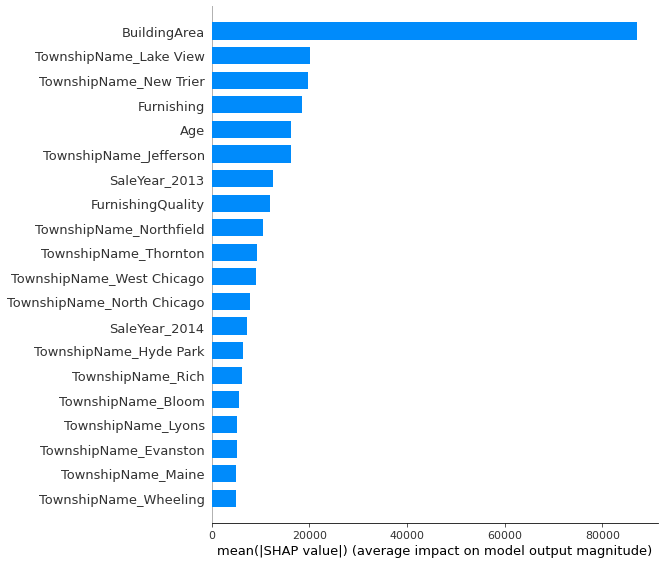

In [19]:
# Overall feature importance from Shap
# Similar to catboost native feature importance
shap.summary_plot(shap_values, x, plot_type="bar")

* Can plot the shap value obtained for every feature for every datapoint. 
* So against building area, we see a scatter of houses. 
* when building area is Red (greater than mean), then its shap value on SalePrice is positive and fairly large. The converse is also true, but not to that extent
* When Age is low, on the other hand, the impact on model output is high. 

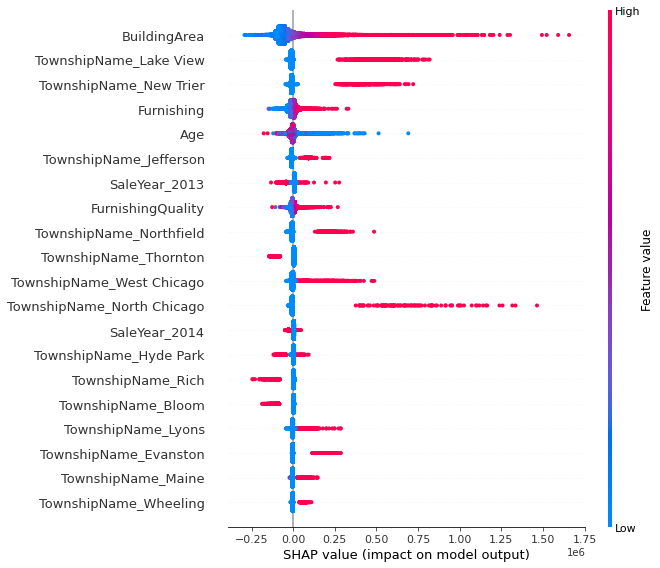

In [20]:
# single feature across the whole dataset
shap.summary_plot(shap_values, x)

<div id='2'/>

# Clustering Houses

<div id='21'/>

## Dimensionality Reduction

* Select a handful of features to attempt summarization on. 
* Ignore location because we cannot use dummies. 

In [21]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
xPCA = df2[['Age', 'BuildingArea', 'Bedrooms', 'FullBaths','BedroomShare', 'Furnishing','FurnishingQuality']]

# ensure these are lowly correlated variables. 
xPCA.corr()

Age  BuildingArea  Bedrooms  FullBaths  BedroomShare  Furnishing  FurnishingQuality
Age                1.000000     -0.306596 -0.101881  -0.321916      0.101606    0.038845           0.047500
BuildingArea      -0.306596      1.000000  0.665040   0.753530     -0.113496    0.387231           0.215038
Bedrooms          -0.101881      0.665040  1.000000   0.574966      0.381178    0.296357           0.177682
FullBaths         -0.321916      0.753530  0.574966   1.000000     -0.077804    0.325998           0.193512
BedroomShare       0.101606     -0.113496  0.381178  -0.077804      1.000000   -0.148994          -0.044707
Furnishing         0.038845      0.387231  0.296357   0.325998     -0.148994    1.000000           0.359351
FurnishingQuality  0.047500      0.215038  0.177682   0.193512     -0.044707    0.359351           1.000000

In [22]:
# Scaling is needed to prevent any feature from dominating the process
x_scaled = normalize(xPCA, axis = 0)

# We compress the data into 3 dimensions
# tSNE can give you a nonlinear decomposition
from sklearn.manifold import TSNE
#pca = TSNE(n_components = 3)
pca = PCA(n_components = 3)

x_transformed = pca.fit_transform(x_scaled)
print('Correl b/w PCA vecs:', np.corrcoef(x_transformed[:, 0], x_transformed[:, 1])[1, 0])

Correl b/w PCA vecs: -3.087776490748803e-16


In [23]:
print('Variance explained by pricipal components:', pca.explained_variance_ratio_)

Variance explained by pricipal components: [0.42731576 0.27475094 0.1343721 ]


In [24]:
print('Total variance explained:', sum(pca.explained_variance_ratio_))

Total variance explained: 0.836438798822978


In [25]:
# Correlation between componants and raw features
# Unable to make out any distinctive details
for j in range(3):
    for i in xPCA.columns: 
        print(f'PCA-{j} with {i}: {np.corrcoef(xPCA[i].values, x_transformed[:, j])[1, 0]}')
    print('\n')

PCA-0 with Age: -0.21198230568691492
PCA-0 with BuildingArea: 0.7215127385258198
PCA-0 with Bedrooms: 0.5526462502427021
PCA-0 with FullBaths: 0.6836530264705851
PCA-0 with BedroomShare: -0.08894692816610908
PCA-0 with Furnishing: 0.5881348312883425
PCA-0 with FurnishingQuality: 0.7895549920909776


PCA-1 with Age: -0.5805132326404021
PCA-1 with BuildingArea: 0.5634353149158888
PCA-1 with Bedrooms: 0.3767929430160811
PCA-1 with FullBaths: 0.5714248083230458
PCA-1 with BedroomShare: -0.03896854978688033
PCA-1 with Furnishing: -0.025843334758890547
PCA-1 with FurnishingQuality: -0.5820627833520584


PCA-2 with Age: 0.7523967871319243
PCA-2 with BuildingArea: 0.19342387834295613
PCA-2 with Bedrooms: 0.30011091126019646
PCA-2 with FullBaths: 0.1368412984901896
PCA-2 with BedroomShare: 0.07678095289409831
PCA-2 with Furnishing: 0.4024776147741286
PCA-2 with FurnishingQuality: -0.18268651787127946




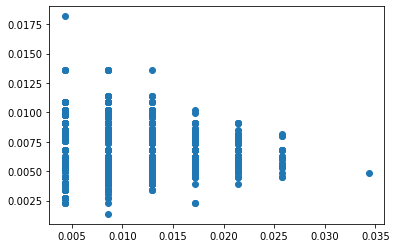

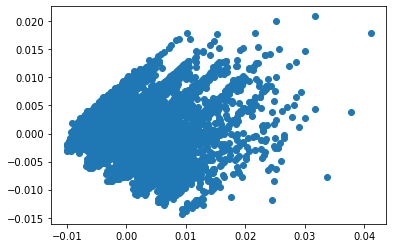

In [26]:
# Scatter plots of features vs components
# Components are uncorrelated
import matplotlib.pyplot as plt
plt.scatter(x_scaled[:, 3], x_scaled[:, 4])
plt.show()

plt.scatter(x_transformed[:, 0], x_transformed[:, 1])
plt.show()

<div id='22'/>

## Clustering Algorithms

* We hunt for clusters in the compressed dimensions
* We evaluate the performance using Silouhette Coefficient which compares inter and intra cluster differences. Values close to 1 represent that clusters are distinctive. 

In [27]:
xKMEANS = x_transformed.copy()
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import cluster, datasets, mixture
from sklearn.metrics import silhouette_samples, silhouette_score as SS
from sklearn.metrics import calinski_harabasz_score as CH, davies_bouldin_score as DB
for i in range(2, 10):
    clusterer = KMeans(n_clusters=i, random_state=10)
    X = normalize(xKMEANS)
    Y = clusterer.fit_predict(X)
    print(i, SS(X, Y), CH(X, Y), DB(X, Y))


2 0.3574265535673283 10929.075870896188 1.2869412526589183
3 0.41169632356418484 13620.085383244521 0.9524207040495641
4 0.40346387362385827 13295.8960447389 0.8989994910158476
5 0.41235926106005105 13911.7235562831 0.9340233563657501
6 0.40625055616245137 13565.312259566663 0.8950675023196423
7 0.3918550105322006 13666.676587777436 0.8889461385565074
8 0.4055723987607966 14005.78039673109 0.8502594029579378
9 0.3965658913359494 14036.3998697645 0.8804399393342154


In [28]:
# taking the best silouhetter score for clusters = 5
import plotly.express as px
dfPCA = xPCA.copy()
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=5, random_state=10, algorithm = 'full')
cluster_labels = clusterer.fit_predict(x_transformed)

In [29]:
# Check the Mean of Variables accross clusters, including SalePrice
dfPCA['clusters'] = np.array(cluster_labels)
dfPCA['SalePrice'] = df2['TSalePrice'].values
dfPCA.groupby('clusters').mean()

Age  BuildingArea  Bedrooms  FullBaths  BedroomShare  Furnishing  FurnishingQuality  SalePrice
clusters                                                                                                       
0          32.061417   2209.589704  3.625382   2.131244      0.499345    3.217890           0.755097  12.613992
1          67.626659   1402.836334  3.098927   1.334424      0.517447    3.232770           2.367885  12.146954
2          57.636459   1147.256414  2.755139   1.060465      0.527091    2.036459           0.576444  11.772690
3          38.944796   3678.730317  4.528507   3.118552      0.495210    4.194570           2.707692  13.635474
4         101.740434   1431.454043  3.121499   1.332544      0.511374    3.494675           0.788166  12.100183

* Cluster 0 (Blue) -> old and small houses, with lot of furnishing but of poorer quality. Lesser number of Bedrooms. Cheap. 
* Cluster 1 (Red) -> young and large houses, with lot of furnishing but of poorer quality. More number of Bedrooms. Costlier than cluster 1. 
* Cluster 4 (Yellow) -> young and large houses, with lot of furnishing but with high quality. More number of Bedrooms. Expensive. 

In [30]:
# Visualise clusters on actual features
from sklearn.cluster import KMeans
fig = px.scatter_3d(dfPCA, x='Age', y='BuildingArea', z='FurnishingQuality', size = 'SalePrice', 
                    color = 'clusters', opacity = 1)
fig.show()

In [31]:
# Visualise clusters on PCA components
# They are more evident here, but less interpretable.
dfPCA_transformed = pd.DataFrame(x_transformed, columns = ['PCA0', 'PCA1', 'PCA2'])
dfPCA_transformed['clusters'] = np.array(cluster_labels)
dfPCA_transformed['SalePrice'] = df2['TSalePrice'].values
from sklearn.cluster import KMeans
fig = px.scatter_3d(dfPCA_transformed, x='PCA0', y='PCA1', z='PCA2', size = 'SalePrice', 
                    color = 'clusters', opacity = 1)
fig.show()

<div id='23'/>

# Factor Analysis

* PCA has this draw back that it creates components sequentially. The first component is allowed to explain as much variance. The others grab whatever is left. The focus is on data compression with orthogonal unit vectors. The focus is not on having these components represent anything. 
* Factor analysis allows us to make adjustments to the data compression so as to allow 'latent factors' instead of 'components'. Factors are supposed to have meaning and correlation with subsets of features. E.g. a students grades accross many exams can be reduced to 'effort' and 'intelligence'. 
* factor analysis is a more interpretable PCA. 
* We will try to decompose every thing into 'quantity' and 'quality'

In [32]:
xFACTOR = df2[['Age', 'BuildingArea','LandSquareFeet', 'Bedrooms', 'Rooms', 'FullBaths', 'Furnishing','FurnishingQuality']].dropna()
xFACTOR.head()

Age  BuildingArea  LandSquareFeet  Bedrooms  Rooms  FullBaths  Furnishing  FurnishingQuality
323685   49        1157.0     7800.000000       3.0    6.0        1.0           1                  0
322936   63         516.0     3919.188192       1.0    2.0        1.0           2                  1
191661   49        1600.0     7700.000000       4.0    7.0        2.0           5                  1
374226   56        1216.0     3431.000000       3.0    7.0        1.0           3                  1
250884   55        1045.0     9569.000000       3.0    6.0        1.0           3                  2

In [33]:
import numpy as np
import statsmodels.api as sm
from statsmodels.multivariate.factor import Factor, FactorResults
X = normalize(xFACTOR.values, axis = 0)
mod = Factor(X, 
             n_factor = 2, 
             endog_names = xFACTOR.columns, 
             method = 'pa')
res = mod.fit()

# We "rotate" to enable factors to be correlated with certain features
# https://community.alteryx.com/t5/Data-Science/Ghost-Hunting-Factor-Analysis-with-Python-and-Alteryx/ba-p/566434
FR = FactorResults(mod)

#Rotations available - varimax, quartimax, biquartimax, equamax, oblimin, parsimax, parsimony, biquartimin, promax.
FR.rotate(method = 'oblimin')
print(FR.summary())

                                  Factor analysis results
                            Eigenvalues                                                    
-------------------------------------------------------------------------------------------
  Age   BuildingArea LandSquareFeet Bedrooms  Rooms  FullBaths Furnishing FurnishingQuality
-------------------------------------------------------------------------------------------
 3.2371       0.5711         0.2368   0.0552 -0.0236   -0.0515    -0.0714           -0.1454
-------------------------------------------------------------------------------------------
                                                                                           
-------------------------------------------------------------------------------------------
                            Communality                                                    
-------------------------------------------------------------------------------------------
   Age   BuildingArea 

Once rotated, the 'factors' are now behaving nicely. The numbers represent correlations between 'factors' and features. 
* Factor 0 correlates with building area, land area, bedrooms and rooms. It represents "quantity"
* Factor 1 corrleates with Furnishing, Furnishing Quality. It represents "quality". 

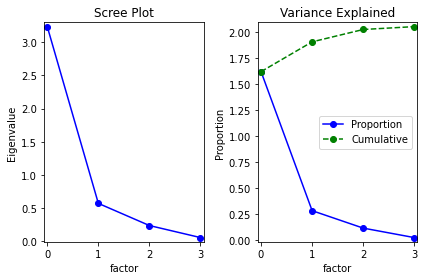

In [34]:
# The scree plot tells us how much variance is explained with more and more factors
res.plot_scree(ncomp=4).show()

[<Figure size 504x504 with 1 Axes>]

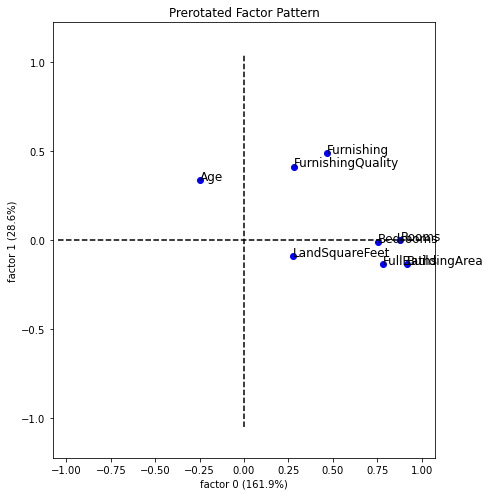

In [35]:
# We plot the loadings, or the direction of features vis-a-vis 'factors'
# This tells us the direction in which features move
# age, furnishing tend to move together i.e Quality
# area, rooms go together i.e quantity
res.plot_loadings()

[<Figure size 504x504 with 1 Axes>]

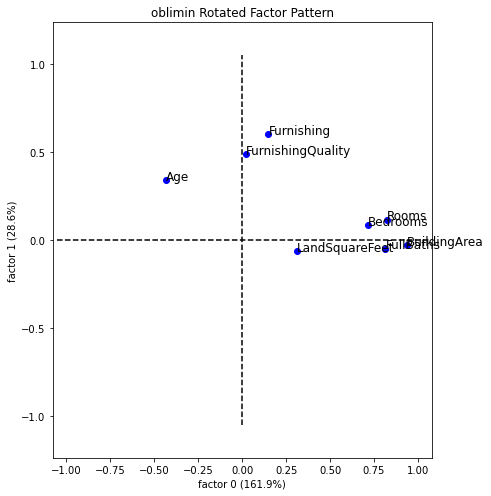

In [36]:
# After rotation this is more magnified
FR.plot_loadings()

In [37]:
FACTORS = np.dot(X, mod.loadings)
xFACTOR['FACTOR0'] = FACTORS[:, 0] * 100
xFACTOR['FACTOR1'] = FACTORS[:, 1] * 100
xFACTOR.head()

Age  BuildingArea  LandSquareFeet  Bedrooms  Rooms  FullBaths  Furnishing  FurnishingQuality   FACTOR0   FACTOR1
323685   49        1157.0     7800.000000       3.0    6.0        1.0           1                  0  1.922609  0.124060
322936   63         516.0     3919.188192       1.0    2.0        1.0           2                  1  1.105986  0.522628
191661   49        1600.0     7700.000000       4.0    7.0        2.0           5                  1  3.225497  0.664072
374226   56        1216.0     3431.000000       3.0    7.0        1.0           3                  1  2.293909  0.569070
250884   55        1045.0     9569.000000       3.0    6.0        1.0           3                  2  2.347519  0.725634

In [38]:
# Factors 0 correlates to Size variables, while factor 1 correlates to quantity. 
xFACTOR.corr()

Age  BuildingArea  LandSquareFeet  Bedrooms     Rooms  FullBaths  Furnishing  FurnishingQuality   FACTOR0   FACTOR1
Age                1.000000     -0.306596       -0.101061 -0.101881 -0.177512  -0.321916    0.038845           0.047500 -0.320184  0.515794
BuildingArea      -0.306596      1.000000        0.301459  0.665040  0.781561   0.753530    0.387231           0.215038  0.915684 -0.105781
LandSquareFeet    -0.101061      0.301459        1.000000  0.215047  0.232541   0.183719    0.092105           0.031039  0.421179 -0.224928
Bedrooms          -0.101881      0.665040        0.215047  1.000000  0.772655   0.574966    0.296357           0.177682  0.758987 -0.011148
Rooms             -0.177512      0.781561        0.232541  0.772655  1.000000   0.655015    0.396050           0.216099  0.851179  0.002265
FullBaths         -0.321916      0.753530        0.183719  0.574966  0.655015   1.000000    0.325998           0.193512  0.834534 -0.130239
Furnishing         0.038845      0.387231        0.092105  0.296357  0.396050   0.325998    1.000000           0.359351  0.525034  0.576117
FurnishingQuality  0.047500      0.215038        0.031039  0.177682  0.216099   0.193512    0.359351           1.000000  0.375153  0.752356
FACTOR0           -0.320184      0.915684        0.421179  0.758987  0.851179   0.834534    0.525034           0.375153  1.000000  0.032332
FACTOR1            0.515794     -0.105781       -0.224928 -0.011148  0.002265  -0.130239    0.576117           0.752356  0.032332  1.000000

In [39]:
xFACTOR.mean()

Age                    59.954430
BuildingArea         1608.111517
LandSquareFeet       7541.463594
Bedrooms                3.170468
Rooms                   6.225923
FullBaths               1.500051
Furnishing              2.913169
FurnishingQuality       1.257908
FACTOR0                 2.628096
FACTOR1                 0.550274
dtype: float64

In [40]:
xFACTOR['HighQuality'] = 0
xFACTOR.loc[xFACTOR.FACTOR1 > 0.592254,  'HighQuality'] = 1
xFACTOR['HighQuantity'] = 0
xFACTOR.loc[xFACTOR.FACTOR0 > 2.663217,  'HighQuantity'] = 1

xFACTOR['Clusters'] = 0
xFACTOR.loc[(xFACTOR.HighQuality == 1) & (xFACTOR.HighQuantity == 0), 'Clusters'] = 1
xFACTOR.loc[(xFACTOR.HighQuality == 0) & (xFACTOR.HighQuantity == 1), 'Clusters'] = 2
xFACTOR.loc[(xFACTOR.HighQuality == 1) & (xFACTOR.HighQuantity == 1), 'Clusters'] = 3


In [41]:
xFACTOR.shape

(19728, 13)

In [42]:
# Manually create clusters - high and low, quantity and quality
xFACTOR['SalePrice'] = df2['TSalePrice'].values
fig = px.scatter(xFACTOR, x='FACTOR0', y='FACTOR1', color = 'Clusters', opacity = 1)
fig.show()